In [28]:
#!pip install EnsemblePursuit
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter, gaussian_filter1d

# Introduction

In this notebook we work with a large-scale calcium imaging recording from the primary visual cortex V1 of the mouse available publicly https://figshare.com/articles/Recording_of_19_000_neurons_across_mouse_visual_cortex_during_sparse_noise_stimuli/9505250 

We apply a sparse matrix factorization algorithm called EnsemblePursuit to extract ensembles of correlated cells from this dataset. The algorithm is available here https://github.com/MouseLand/EnsemblePursuit It can be pip installed ('pip install EnsemblePursuit').

The following notebook explored the relationship between the spatial organization of cells in the ensemble and their relationship to stimuli in receptive fields and behavioral data in the form of motion energy of the mouse's face extracted via the SVD algorithm, https://github.com/MouseLand/EnsemblePursuit/blob/master/Notebooks/BehaviorStimulusCorrsWithSpatialSpreadOfEnsemble.ipynb Specifically, we use ridge regression to map from stimulus and behavioral components to the average activity of the cells in ensemble and quantify how well the learned models can predict the activity of the ensemble on test data (quantified through correlation of the predicted timeseries with the actual timeseries). 

We found that ensembles that exhibit linear receptive fields are localized in space while ensembles that are best explained by behavior display higher spatial variance. 

In this notebook we take inspiration from a paper that found that the synapses between neurons with similar receptive fields are very strong, while synapses that are formed between cells that do not show correlation in their responses are weak. 

We create an artificial neuron that receives strong inputs from a "sensory" ensemble (ensemble with a receptive field) and weak inputs from a spatially spread out "behavioral ensemble" (ensemble taht is well predicted by behavioral motion SVD's). We endow the neuron with the BCM plasticity rule and study the evolution of synaptic weights and the change in recepti

# Extracting Ensembles of Correlated Cells

In [2]:

data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
#Uncomment to compute U and V
#ep=EnsemblePursuit(n_components=50,lam=0.01,n_kmeans=50)
#model=ep.fit(S.T[:10000,:])
#V=model.components_
#U=model.weights
#np.save('U.npy',U)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)
obtained 50 PCs in 7.1065 seconds
initialized 50 clusters with k-means in 19.2944 seconds
ensemble 0, time 13.25, nr neurons 6337, EV 0.0086
ensemble 25, time 65.89, nr neurons 268, EV 0.0333
ensemble 49, time 95.60, nr neurons 130, EV 0.0420
average sparsity is 0.0274


In [3]:
del spks

(18795, 50)
None
(642,)


(array([ 29., 135., 154., 126.,  91.,  56.,  29.,  16.,   5.,   1.]),
 array([ 2.14707851,  3.78068523,  5.41429196,  7.04789868,  8.6815054 ,
        10.31511213, 11.94871885, 13.58232558, 15.2159323 , 16.84953903,
        18.48314575]),
 <a list of 10 Patch objects>)

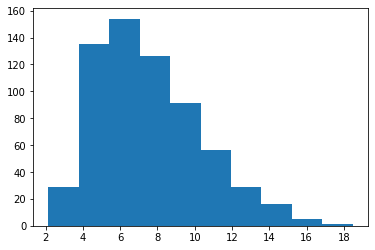

In [15]:
#Select stim ensemble, make weights for stim ens
print(print(U.shape))
stim_ens_inds=np.nonzero(U[:,13])[0]
print(stim_ens_inds.shape)
stim_k=7.5
stim_theta=1.0
stim_weights=np.random.gamma(shape=stim_k,scale=stim_theta,size=(stim_ens_inds.shape[0],))
plt.hist(stim_weights)

(463,)


(array([213., 104.,  73.,  34.,  18.,   8.,   6.,   4.,   1.,   2.]),
 array([9.47150978e-03, 1.24141016e+00, 2.47334881e+00, 3.70528746e+00,
        4.93722611e+00, 6.16916476e+00, 7.40110341e+00, 8.63304206e+00,
        9.86498071e+00, 1.10969194e+01, 1.23288580e+01]),
 <a list of 10 Patch objects>)

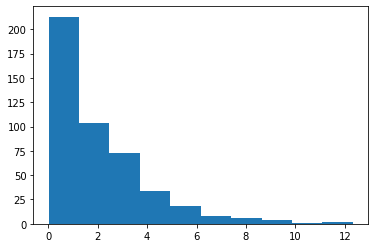

In [14]:
#Select beh ensemble, make weights for stim_ens
beh_ens_inds=np.nonzero(U[:,8])[0]
print(beh_ens_inds.shape)
beh_k=1.0
beh_theta=2.0
beh_weights=np.random.gamma(shape=beh_k,scale=beh_theta,size=(beh_ens_inds.shape[0],))
plt.hist(beh_weights)

In [12]:
weights=np.hstack((stim_weights,beh_weights))
print(weights.shape)

(1105,)


In [20]:
stim_inp=S[stim_ens_inds]
beh_imp=S[beh_ens_inds]
input_patterns=np.vstack((stim_inp,beh_imp))

In [19]:
print(stim_inp.shape)

(642, 30560)


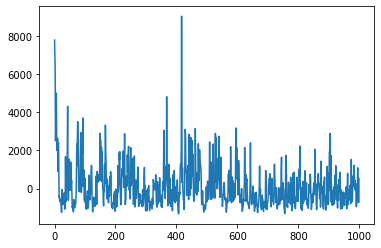

In [26]:
v_lst=[np.dot(weights,input_patterns[:,0])]
for j in range(1,30560):
    v_lst.append(np.dot(weights,input_patterns[:,j]))
plt.plot(v_lst[:1000])
plt.show()
v_lst=np.array(v_lst)

In [30]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = v_lst.shape[0]
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
#ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ v_lst[itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.5, .5, 0])

30560


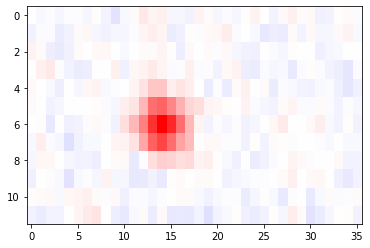

In [31]:
rf = B0[:,:,0]
rfmax = np.max(B0)
# rfmax = np.max(np.abs(rf))
plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax)